# Skyfield solar terminator

We pretend to plot the solar terminator in our Caribbean maps and found this functions which help us to archieve this goal. Credits to JoshPaterson, which gave an script available at https://github.com/skyfielders/python-skyfield/discussions/602. I made some modifications to adjust the program for my needs.

In [53]:
from skyfield.api import load
from skyfield.api import wgs84
import numpy as np
from skyfield.positionlib import Geocentric

eph = load('de421.bsp')
earth = eph['earth'] # vector from solar system barycenter to geocenter
sun = eph['sun'] # vector from solar system barycenter to sun
geocentric_sun = sun - earth # vector from geocenter to sun

ts = load.timescale()
t = ts.utc(2019, 6, 22, 21, 25, 48.)

sun_subpoint = wgs84.subpoint(geocentric_sun.at(t)) # subpoint method requires a geocentric position

print('subpoint latitude: ', sun_subpoint.latitude.degrees)
print('subpoint longitude: ', sun_subpoint.longitude.degrees)


def cross_product_matrix(a):
    """ computes the cross product matrix

    see https://en.wikipedia.org/wiki/Cross_product#Conversion_to_matrix_multiplication
    code from https://stackoverflow.com/questions/66707295/numpy-cross-product-matrix-function
    """
    return np.cross(a, np.identity(3) * -1)

def rotation_matrix_around_axis(axis_vector, rotation_degrees):
    """ creates a rotation matrix that rotates around a given axis

    see https://en.wikipedia.org/wiki/Rotation_matrix#Rotation_matrix_from_axis_and_angle
    """
    rotation_radians = rotation_degrees / 180 * np.pi
    return (
        np.cos(rotation_radians) * np.identity(3)
        + np.sin(rotation_radians) * cross_product_matrix(axis_vector)
        + (1 - np.cos(rotation_radians)) * np.outer(axis_vector, axis_vector)
        )

terminator_angle_from_sun = 90.833 # 90 degrees + sun's semidiameter + refraction at horizon

sun_vec = geocentric_sun.at(t).position.au # numpy array of sun's position vector
normal_vec = np.cross(sun_vec, np.array([1,0,0]))# vector normal to sun position and x-axis
first_terminator_vec = rotation_matrix_around_axis(normal_vec, terminator_angle_from_sun) @ sun_vec # arbitrary first position on terminator

terminator_latitudes = []
terminator_longitudes = []

num_points_on_terminator = 100
for angle in np.linspace(0, 360, num_points_on_terminator):
    terminator_vector = rotation_matrix_around_axis(sun_vec, angle) @ first_terminator_vec
    terminator_position = Geocentric(terminator_vector, t=t)
    geographic_position = wgs84.subpoint(terminator_position)
    terminator_latitudes.append(geographic_position.latitude.degrees)
    terminator_longitudes.append(geographic_position.longitude.degrees)

terminator_latitudes = np.array(terminator_latitudes)
terminator_longitudes = np.array(terminator_longitudes)

subpoint latitude:  23.430357981260226
subpoint longitude:  -140.93194210400986


## Incorporate caribbean map to the solar terminator

In [54]:
import seaborn as sns
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
from plotfullmap import plot_map
import argparse
from astropy.table import Table
import glob
import matplotlib.cm as cm
from scipy.interpolate import griddata
from midpoint import MidpointNormalize
import datetime

In [55]:
sns.set_style("whitegrid") 
sns.mpl.rc("figure", figsize=(10,6))

### Incorporate recorded Ionospheric pierce point coordinates

In [56]:
f = open("./data/2019-06-22/set4/cn19173-2019-06-22.Cmn", "r")
for i in range(4):
    f.readline()
raw_data = f.readlines()
cmn_data = Table.read(raw_data, format="ascii")
s_lats, s_lons = cmn_data["Lat"], cmn_data["Lon"]-360.
time = cmn_data["Time"]
starttime = 21. + 25/60. +48./3600.
time_window = (time> max(starttime-2.5, 0.0)) & (time< min(starttime+3.5, 24.0))
prn_list = [2, 5, 6, 9, 12, 13, 17, 19]
prn_text_coords_x= [-72.5, -74.5, -62.5, -63.5, -74, -70, -64.9, -68]
prn_text_coords_y= [16.6, 4, 11, 9, 12, 4, 6, 7]
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

### Incorporate meteor position and station position

Based on data available at [https://cneos.jpl.nasa.gov/fireballs/](https://cneos.jpl.nasa.gov/fireballs/), we find the following information about the meteor paramenters:
- Date and time of fragmentation: 2019-06-22 (2019 June 22th) 21:25:48 UT
- Latitude and Longitude: 14.9, -66.2
- Altitude: 25.0 km
- Velocity: 14.9 km/s
- Velocity components: $v_x = -13.4$, $v_y=6.0$, $v_z = 2.5$
  where $v_x$ is the velocity along the equatorial plane towards the prime meridian, $v_z$ is the velocity along the earth's    rotation axis, towards the north celestial pole and $v_y$ complets the right handed coordinate system
- Total radiated energy: $2.8 \times 10^{10}~J$
- Calculated total impact energy: 6 kt

In [57]:
y_lat, x_lon = np.array((14.9)), np.array((-66.2))
v_eq = np.array((-13.4))
v_lat = np.array((2.5*np.cos(np.radians(y_lat))- 6.0*np.sin(np.radians(y_lat))))
re, h = 6371, 25
t = np.linspace(-60., 4.5)
xm, ym = np.degrees(v_eq/(re+h)*t)+x_lon, np.degrees(v_lat/(re+h)*t)+y_lat
s_data = pd.read_csv("station_data.csv")
s_lat, s_lon = s_data["Latitude"][s_data["Site"]=="CN19"], s_data["Longitude"][s_data["Site"]=="CN19"]

### Incorporate GLM data

In [58]:
GLM_data = pd.read_csv("./data/2019-06-22/GLM16-data.csv", header = 9)
Lat, Lon = GLM_data["latitude"], GLM_data["longitude"]
GLM_data.head(5)

,time (ms),longitude,latitude,energy (joules)
0,1561238745265,-65.776215,14.906006,1.525970e-15
1,1561238745468,-65.807884,14.905684,4.577910e-15
2,1561238745470,-65.810646,14.905668,3.051940e-15
3,1561238745472,-65.811707,14.905637,4.577910e-15
4,1561238745474,-65.822113,14.905485,4.577910e-15


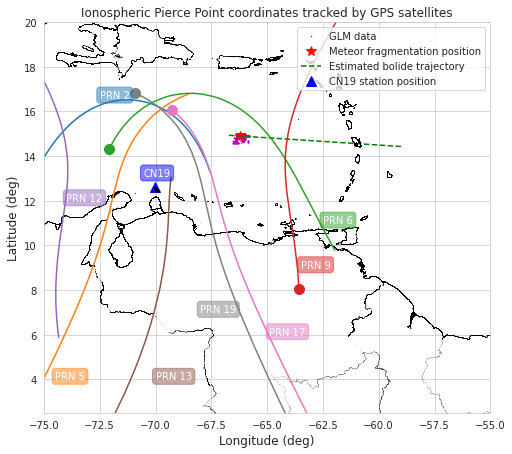

In [59]:
f = plt.figure()
ax = f.add_subplot(111, aspect="equal")
caribe = glob.glob("./Map/*.shp")
k=0
ax.plot(Lon, Lat, "m.", ms=1, label = "GLM data")
ax.plot(x_lon, y_lat, "r*", ms=10, label = "Meteor fragmentation position")
ax.plot(xm, ym, "g--", label="Estimated bolide trajectory")
ax.plot(s_lon, s_lat, "b^", ms=10, label="CN19 station position")
ax.text(s_lon-0.5, s_lat+0.5, "CN19", color="w", bbox=dict(boxstyle="round", color="blue", alpha=0.5), fontsize="medium")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, "k.", ms=0.025)
for j,p in enumerate(prn_list):
    prn_mask = cmn_data["PRN"] == p
    props = dict(boxstyle="round", color=colors[k], alpha=0.5)
    ax.plot(s_lons[prn_mask & time_window], s_lats[prn_mask &time_window])
    ax.plot(s_lons[prn_mask & time_window][0], s_lats[prn_mask &time_window][0], "o", c=colors[k], ms=10)
    ax.text(prn_text_coords_x[j], prn_text_coords_y[j], "PRN {}".format(p), c="w", bbox =props, fontsize="medium")
    k+=1
#ax.scatter(terminator_longitudes, terminator_latitudes)
#ax.scatter(sun_subpoint.longitude.degrees, sun_subpoint.latitude.degrees)
ax.fill_between(terminator_longitudes, -70, terminator_latitudes, color="blue", alpha=0.5)
ax.set_xlim(-75, -55)
ax.set_ylim(2.5, 20)
ax.legend(loc="upper right", fontsize="medium")
ax.set_xlabel("Longitude (deg)", fontsize="large")
ax.set_ylabel("Latitude (deg)", fontsize="large")
ax.set_title("Ionospheric Pierce Point coordinates tracked by GPS satellites", fontsize="large")
f.set_size_inches(8, 8)
f.savefig("./paper/figures/cn19_satellites_positions_terminator_21-25-48.png")

### Repeat with boav station 

In [60]:
f = open("./data/2019-06-22/set5/boav173-2019-06-22.Cmn", "r")
for i in range(4):
    f.readline()
raw_data = f.readlines()
cmn_data = Table.read(raw_data, format="ascii")
s_lats, s_lons = cmn_data["Lat"], cmn_data["Lon"]-360.
time = cmn_data["Time"]
starttime = 21. + 25/60. +48./3600.
time_window = (time> max(starttime-2.5, 0.0)) & (time< min(starttime+3.5, 24.0))
prn_list = [2, 5, 6, 9, 12, 13, 17, 19]
prn_text_coords_x= [-65, -65, -60, -55, -71, -63, -58.8, -60.8]
prn_text_coords_y= [9.5, 4, 9, 12, 10, 2, 3, 0.5]

/tmp/ipykernel_10740/796874078.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f.savefig("./paper/figures/boav_satellites_positions_terminator_21-25-48.png")
/home/antikythera/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


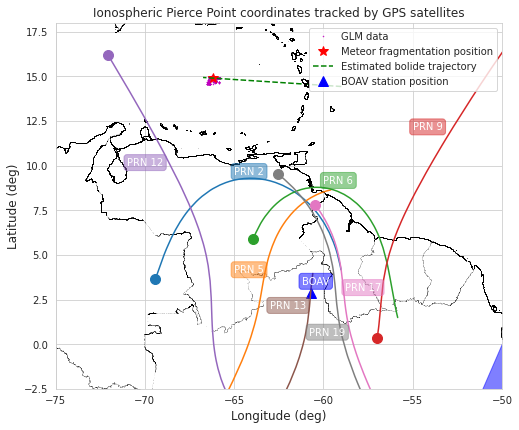

In [61]:
s_lat2, s_lon2 = s_data["Latitude"][s_data["Site"]=="BOAV"], s_data["Longitude"][s_data["Site"]=="BOAV"]
f = plt.figure()
ax = f.add_subplot(111, aspect="equal")
k=0
ax.plot(Lon, Lat, "m.", ms=1, label = "GLM data")
ax.plot(x_lon, y_lat, "r*", ms=10, label = "Meteor fragmentation position")
ax.plot(xm, ym, "g--", label="Estimated bolide trajectory")
ax.plot(s_lon2, s_lat2, "b^", ms=10, label="BOAV station position")
ax.text(s_lon2-0.5, s_lat2+0.5, "BOAV", color="w", bbox=dict(boxstyle="round", color="blue", alpha=0.5), fontsize="medium")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, "k.", ms=0.025)
for j,p in enumerate(prn_list):
    prn_mask = cmn_data["PRN"] == p
    props = dict(boxstyle="round", color=colors[k], alpha=0.5)
    ax.plot(s_lons[prn_mask & time_window], s_lats[prn_mask &time_window])
    ax.plot(s_lons[prn_mask & time_window][0], s_lats[prn_mask &time_window][0], "o", c=colors[k], ms=10)
    ax.text(prn_text_coords_x[j], prn_text_coords_y[j], "PRN {}".format(p), c="w", bbox=props, fontsize="medium")
    k+=1
#ax.scatter(terminator_longitudes, terminator_latitudes)
#ax.scatter(sun_subpoint.longitude.degrees, sun_subpoint.latitude.degrees)
ax.fill_between(terminator_longitudes, -70, terminator_latitudes, color="blue", alpha=0.5)
ax.set_xlim(-75, -50)
ax.set_ylim(-2.5, 18)
ax.legend(fontsize="medium")
ax.set_xlabel("Longitude (deg)", fontsize="large")
ax.set_ylabel("Latitude (deg)", fontsize="large")
ax.set_title("Ionospheric Pierce Point coordinates tracked by GPS satellites", fontsize="large")
f.set_size_inches(8, 8)
f.savefig("./paper/figures/boav_satellites_positions_terminator_21-25-48.png")

### Repeat with KOUG station 

In [62]:
f = open("./data/2019-06-22/set5/koug173-2019-06-22.Cmn", "r")
for i in range(4):
    f.readline()
raw_data = f.readlines()
cmn_data = Table.read(raw_data, format="ascii")
s_lats, s_lons = cmn_data["Lat"], cmn_data["Lon"]-360.
time = cmn_data["Time"]
starttime = 21. + 25/60. +48./3600.
time_window = (time> max(starttime-2.5, 0.0)) & (time< min(starttime+3.5, 24.0))
prn_list = [2, 5, 6, 9, 12, 13, 17, 19]
prn_text_coords_x= [-65, -58.2, -58, -50, -64.1, -55.5, -51.5, -53]
prn_text_coords_y= [9.5, 4, 9, 9, 12, 2, 6, 1]

/tmp/ipykernel_10740/1322214795.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f.savefig("./paper/figures/koug_satellites_positions_terminator_21-25-48.png")
/home/antikythera/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


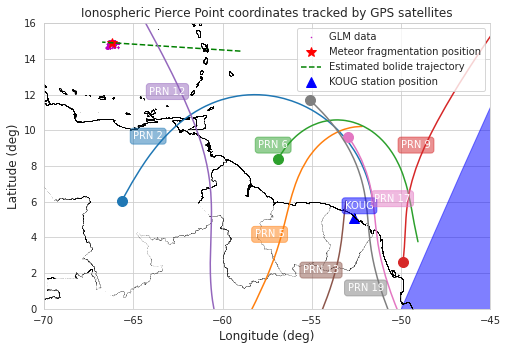

In [63]:
s_lat3, s_lon3 = s_data["Latitude"][s_data["Site"]=="KOUG"], s_data["Longitude"][s_data["Site"]=="KOUG"]
f = plt.figure()
ax = f.add_subplot(111, aspect="equal")
k=0
ax.plot(Lon, Lat, "m.", ms=1, label = "GLM data")
ax.plot(x_lon, y_lat, "r*", ms=10, label = "Meteor fragmentation position")
ax.plot(xm, ym, "g--", label="Estimated bolide trajectory")
ax.plot(s_lon3, s_lat3, "b^", ms=10, label="KOUG station position")
ax.text(s_lon3-0.5, s_lat3+0.5, "KOUG", color="w", bbox=dict(boxstyle="round", color="blue", alpha=0.5), fontsize="medium")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, "k.", ms=0.025)
for j,p in enumerate(prn_list):
    prn_mask = cmn_data["PRN"] == p
    props = dict(boxstyle="round", color=colors[k], alpha=0.5)
    ax.plot(s_lons[prn_mask & time_window], s_lats[prn_mask &time_window])
    ax.plot(s_lons[prn_mask & time_window][0], s_lats[prn_mask &time_window][0], "o", c=colors[k], ms=10)
    ax.text(prn_text_coords_x[j], prn_text_coords_y[j], "PRN {}".format(p), c="w", bbox=props, fontsize="medium")
    k+=1
#ax.scatter(terminator_longitudes, terminator_latitudes)
#ax.scatter(sun_subpoint.longitude.degrees, sun_subpoint.latitude.degrees)
ax.fill_between(terminator_longitudes, -70, terminator_latitudes, color="blue", alpha=0.5)
ax.set_xlim(-70, -45)
ax.set_ylim(0, 16)
ax.legend()
ax.set_xlabel("Longitude (deg)", fontsize="large")
ax.set_ylabel("Latitude (deg)", fontsize="large")
ax.set_title("Ionospheric Pierce Point coordinates tracked by GPS satellites", fontsize="large")
f.set_size_inches(8, 8)
f.savefig("./paper/figures/koug_satellites_positions_terminator_21-25-48.png")

## Plot maps of remaining stations

### GRE1

In [64]:
f = open("./data/2019-06-22/set3/gre1173-2019-06-22.Cmn", "r")
for i in range(4):
    f.readline()
raw_data = f.readlines()
cmn_data = Table.read(raw_data, format="ascii")
s_lats, s_lons = cmn_data["Lat"], cmn_data["Lon"]-360.
time = cmn_data["Time"]
starttime = 21. + 25/60. +48./3600.
time_window = (time> max(starttime-2.5, 0.0)) & (time< min(starttime+3.5, 24.0))
prn_list = [2, 5, 6, 9, 12, 13, 17, 19]
prn_text_coords_x= [-69, -65.9, -59, -57.5, -66.8, -63.2, -58, -60.2]
prn_text_coords_y= [15, 7, 16, 17, 13, 9, 7, 7]

/tmp/ipykernel_10740/112118602.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig("./paper/figures/gre1_satellites_positions_terminator_21-25-48.png")
/home/antikythera/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


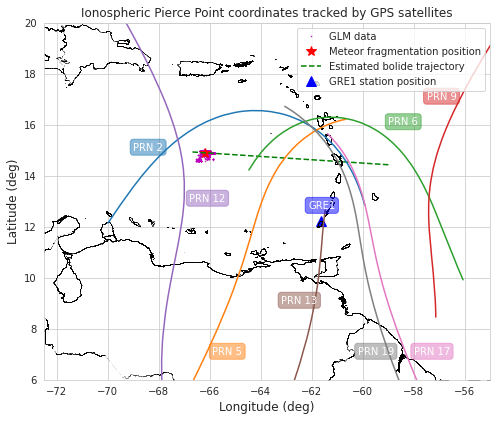

In [65]:
s_lat4, s_lon4 = s_data["Latitude"][s_data["Site"]=="GRE1"], s_data["Longitude"][s_data["Site"]=="GRE1"]
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")
k=0
ax.plot(Lon, Lat, "m.", ms=1, label = "GLM data")
ax.plot(x_lon, y_lat, "r*", ms=10, label = "Meteor fragmentation position")
ax.plot(xm, ym, "g--", label="Estimated bolide trajectory")
ax.plot(s_lon4, s_lat4, "b^", ms=10, label="GRE1 station position")
ax.text(s_lon4-0.5, s_lat4+0.5, "GRE1", color="w", bbox=dict(boxstyle="round", color="blue", alpha=0.5), fontsize="medium")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, "k.", ms=0.025)
for j,p in enumerate(prn_list):
    prn_mask = cmn_data["PRN"] == p
    props = dict(boxstyle="round", color=colors[k], alpha=0.5)
    ax.plot(s_lons[prn_mask & time_window], s_lats[prn_mask &time_window])
    ax.text(prn_text_coords_x[j], prn_text_coords_y[j], "PRN {}".format(p), c="w", bbox=props, fontsize="medium")
    k+=1
#ax.scatter(terminator_longitudes, terminator_latitudes)
#ax.scatter(sun_subpoint.longitude.degrees, sun_subpoint.latitude.degrees)
ax.fill_between(terminator_longitudes, -70, terminator_latitudes, color="blue", alpha=0.5)
ax.set_xlim(-72.5, -55)
ax.set_ylim(6, 20)
ax.legend()
ax.set_xlabel("Longitude (deg)", fontsize="large")
ax.set_ylabel("Latitude (deg)", fontsize="large")
ax.set_title("Ionospheric Pierce Point coordinates tracked by GPS satellites", fontsize="large")
fig.set_size_inches(8, 8)
fig.savefig("./paper/figures/gre1_satellites_positions_terminator_21-25-48.png")

### TTSF

In [66]:
f = open("./data/2019-06-22/set4/ttsf173-2019-06-22.Cmn", "r")
for i in range(4):
    f.readline()
raw_data = f.readlines()
cmn_data = Table.read(raw_data, format="ascii")
s_lats, s_lons = cmn_data["Lat"], cmn_data["Lon"]-360.
time = cmn_data["Time"]
starttime = 21. + 25/60. +48./3600.
time_window = (time> max(starttime-2.5, 0.0)) & (time< min(starttime+3.5, 24.0))
prn_list = [2, 5, 6, 9, 12, 13, 17, 19]
prn_text_coords_x= [-69, -66.1, -59, -57.5, -66.8, -63.2, -59, -60.7]
prn_text_coords_y= [13, 7, 12.5, 15, 13, 9, 9, 6.5]

/tmp/ipykernel_10740/949956486.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig("./paper/figures/ttsf_satellites_positions_terminator_21-25-48.png")
/home/antikythera/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


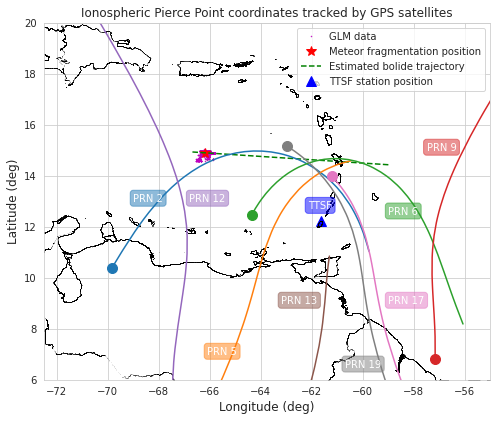

In [67]:
s_lat5, s_lon5 = s_data["Latitude"][s_data["Site"]=="TTSF"], s_data["Longitude"][s_data["Site"]=="TTSF"]
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")
k=0
ax.plot(Lon, Lat, "m.", ms=1, label = "GLM data")
ax.plot(x_lon, y_lat, "r*", ms=10, label = "Meteor fragmentation position")
ax.plot(xm, ym, "g--", label="Estimated bolide trajectory")
ax.plot(s_lon4, s_lat4, "b^", ms=10, label="TTSF station position")
ax.text(s_lon4-0.5, s_lat4+0.5, "TTSF", color="w", bbox=dict(boxstyle="round", color="blue", alpha=0.5), fontsize="medium")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, "k.", ms=0.025)
for j,p in enumerate(prn_list):
    prn_mask = cmn_data["PRN"] == p
    props = dict(boxstyle="round", color=colors[k], alpha=0.5)
    ax.plot(s_lons[prn_mask & time_window], s_lats[prn_mask &time_window])
    ax.plot(s_lons[prn_mask & time_window][0], s_lats[prn_mask &time_window][0], "o", c=colors[k], ms=10)
    ax.text(prn_text_coords_x[j], prn_text_coords_y[j], "PRN {}".format(p), c="w", bbox=props, fontsize="medium")
    k+=1
#ax.scatter(terminator_longitudes, terminator_latitudes)
#ax.scatter(sun_subpoint.longitude.degrees, sun_subpoint.latitude.degrees)
ax.fill_between(terminator_longitudes, -70, terminator_latitudes, color="blue", alpha=0.5)
ax.set_xlim(-72.5, -55)
ax.set_ylim(6, 20)
ax.legend()
ax.set_xlabel("Longitude (deg)", fontsize="large")
ax.set_ylabel("Latitude (deg)", fontsize="large")
ax.set_title("Ionospheric Pierce Point coordinates tracked by GPS satellites", fontsize="large")
fig.set_size_inches(8, 8)
fig.savefig("./paper/figures/ttsf_satellites_positions_terminator_21-25-48.png")

### CN40

In [68]:
f = open("./data/2019-06-22/set4/cn40173-2019-06-22.Cmn", "r")
for i in range(4):
    f.readline()
raw_data = f.readlines()
cmn_data = Table.read(raw_data, format="ascii")
s_lats, s_lons = cmn_data["Lat"], cmn_data["Lon"]-360.
time = cmn_data["Time"]
starttime = 21. + 25/60. +48./3600.
time_window = (time> max(starttime-2.5, 0.0)) & (time< min(starttime+3.5, 24.0))
prn_list = [2, 5, 6, 9, 12, 13, 17, 19]
prn_text_coords_x= [-72, -70, -66, -61, -72.8, -70, -65, -67.5]
prn_text_coords_y= [16.5, 13, 16.5, 18.5, 13, 9, 9, 9]

/tmp/ipykernel_10740/3362542728.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig("./paper/figures/cn40_satellites_positions_terminator_21-25-48.png")
/home/antikythera/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


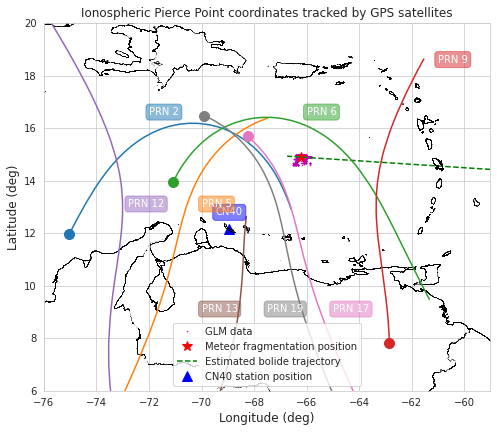

In [69]:
s_lat5, s_lon5 = s_data["Latitude"][s_data["Site"]=="CN40"], s_data["Longitude"][s_data["Site"]=="CN40"]
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")
k=0
ax.plot(Lon, Lat, "m.", ms=1, label = "GLM data")
ax.plot(x_lon, y_lat, "r*", ms=10, label = "Meteor fragmentation position")
ax.plot(xm, ym, "g--", label="Estimated bolide trajectory")
ax.plot(s_lon5, s_lat5, "b^", ms=10, label="CN40 station position")
ax.text(s_lon5-0.5, s_lat5+0.5, "CN40", color="w", bbox=dict(boxstyle="round", color="blue", alpha=0.5), fontsize="medium")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, "k.", ms=0.025)
for j,p in enumerate(prn_list):
    prn_mask = cmn_data["PRN"] == p
    props = dict(boxstyle="round", color=colors[k], alpha=0.5)
    ax.plot(s_lons[prn_mask & time_window], s_lats[prn_mask &time_window])
    ax.plot(s_lons[prn_mask & time_window][0], s_lats[prn_mask &time_window][0], "o", c=colors[k], ms=10)
    ax.text(prn_text_coords_x[j], prn_text_coords_y[j], "PRN {}".format(p), c="w", bbox=props, fontsize="medium")
    k+=1
#ax.scatter(terminator_longitudes, terminator_latitudes)
#ax.scatter(sun_subpoint.longitude.degrees, sun_subpoint.latitude.degrees)
ax.fill_between(terminator_longitudes, -70, terminator_latitudes, color="blue", alpha=0.5)
ax.set_xlim(-76, -59)
ax.set_ylim(6, 20)
ax.legend()
ax.set_xlabel("Longitude (deg)", fontsize="large")
ax.set_ylabel("Latitude (deg)", fontsize="large")
ax.set_title("Ionospheric Pierce Point coordinates tracked by GPS satellites", fontsize="large")
fig.set_size_inches(8, 8)
fig.savefig("./paper/figures/cn40_satellites_positions_terminator_21-25-48.png")

### CN04

In [70]:
f = open("./data/2019-06-22/set3/cn04173-2019-06-22.Cmn", "r")
for i in range(4):
    f.readline()
raw_data = f.readlines()
cmn_data = Table.read(raw_data, format="ascii")
s_lats, s_lons = cmn_data["Lat"], cmn_data["Lon"]-360.
time = cmn_data["Time"]
starttime = 21. + 25/60. +48./3600.
time_window = (time> max(starttime-2.5, 0.0)) & (time< min(starttime+3.5, 24.0))
prn_list = [2, 5, 6, 9, 12, 13, 17, 19]
prn_text_coords_x= [-69, -65, -64.4, -57.8, -68.5, -63, -57.5, -59.7]
prn_text_coords_y= [16.5, 13, 16.5, 17, 13, 9, 9, 9]

/tmp/ipykernel_10740/3876252482.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig("./paper/figures/cn04_satellites_positions_terminator_21-25-48.png")
/home/antikythera/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


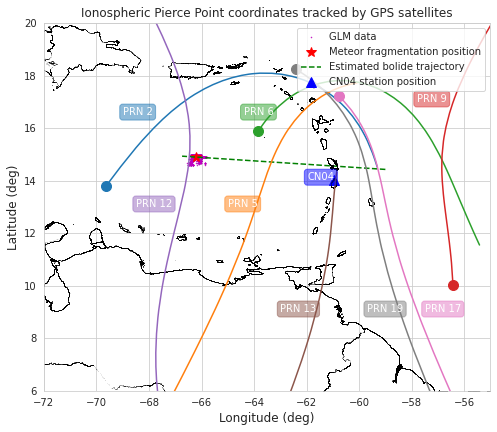

In [71]:
s_lat6, s_lon6 = s_data["Latitude"][s_data["Site"]=="CN04"], s_data["Longitude"][s_data["Site"]=="CN04"]
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")
k=0
ax.plot(Lon, Lat, "m.", ms=1, label = "GLM data")
ax.plot(x_lon, y_lat, "r*", ms=10, label = "Meteor fragmentation position")
ax.plot(xm, ym, "g--", label="Estimated bolide trajectory")
ax.plot(s_lon6, s_lat6, "b^", ms=10, label="CN04 station position")
ax.text(s_lon6-1, s_lat6, "CN04", color="w", bbox=dict(boxstyle="round", color="blue", alpha=0.5), fontsize="medium")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, "k.", ms=0.025)
for j,p in enumerate(prn_list):
    prn_mask = cmn_data["PRN"] == p
    props = dict(boxstyle="round", color=colors[k], alpha=0.5)
    ax.plot(s_lons[prn_mask & time_window], s_lats[prn_mask &time_window])
    ax.plot(s_lons[prn_mask & time_window][0], s_lats[prn_mask &time_window][0], "o", c=colors[k], ms=10)
    ax.text(prn_text_coords_x[j], prn_text_coords_y[j], "PRN {}".format(p), c="w", bbox=props, fontsize="medium")
    k+=1
#ax.scatter(terminator_longitudes, terminator_latitudes)
#ax.scatter(sun_subpoint.longitude.degrees, sun_subpoint.latitude.degrees)
ax.fill_between(terminator_longitudes, -70, terminator_latitudes, color="blue", alpha=0.5)
ax.set_xlim(-72, -55)
ax.set_ylim(6, 20)
ax.legend()
ax.set_xlabel("Longitude (deg)", fontsize="large")
ax.set_ylabel("Latitude (deg)", fontsize="large")
ax.set_title("Ionospheric Pierce Point coordinates tracked by GPS satellites", fontsize="large")
fig.set_size_inches(8, 8)
fig.savefig("./paper/figures/cn04_satellites_positions_terminator_21-25-48.png")

## Sunset test

In this section we will test at what time sunset occured at BOAV, KOUG and KOUR stations

In [72]:
ts = load.timescale()
t = ts.utc(2019, 6, 22, 21, 45, 0)
t2 = ts.utc(2019, 6, 22, 22, 13, 0)
sun_subpoint = wgs84.subpoint(geocentric_sun.at(t)) # subpoint method requires a geocentric position
terminator_angle_from_sun = 90.833 # 90 degrees + sun's semidiameter + refraction at horizon

sun_vec = geocentric_sun.at(t).position.au # numpy array of sun's position vector
normal_vec = np.cross(sun_vec, np.array([1,0,0]))# vector normal to sun position and x-axis
first_terminator_vec = rotation_matrix_around_axis(normal_vec, terminator_angle_from_sun) @ sun_vec # arbitrary first position on terminator

terminator_latitudes = []
terminator_longitudes = []
terminator_latitudes2 = []
terminator_longitudes2 = []


num_points_on_terminator = 100
for angle in np.linspace(0, 360, num_points_on_terminator):
    terminator_vector = rotation_matrix_around_axis(sun_vec, angle) @ first_terminator_vec
    terminator_position = Geocentric(terminator_vector, t=t)
    terminator_position2 = Geocentric(terminator_vector, t=t2)
    geographic_position = wgs84.subpoint(terminator_position)
    geographic_position2 = wgs84.subpoint(terminator_position2)
    terminator_latitudes.append(geographic_position.latitude.degrees)
    terminator_longitudes.append(geographic_position.longitude.degrees)
    terminator_latitudes2.append(geographic_position2.latitude.degrees)
    terminator_longitudes2.append(geographic_position2.longitude.degrees)

terminator_latitudes = np.array(terminator_latitudes)
terminator_longitudes = np.array(terminator_longitudes)
terminator_latitudes2 = np.array(terminator_latitudes2)
terminator_longitudes2 = np.array(terminator_longitudes2)

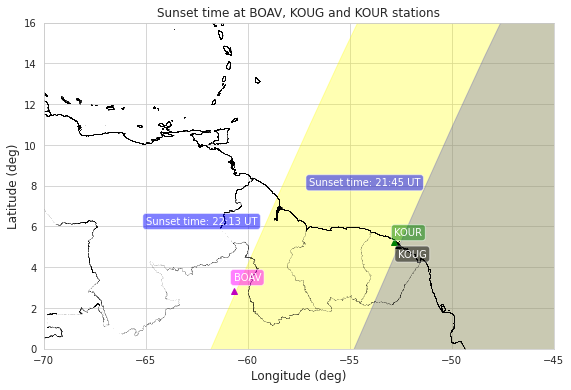

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, "k.", ms=0.025)
boav_y, boav_x = s_data["Latitude"][s_data["Site"]=="BOAV"], s_data["Longitude"][s_data["Site"]=="BOAV"]
koug_y, koug_x = s_data["Latitude"][s_data["Site"]=="KOUG"], s_data["Longitude"][s_data["Site"]=="KOUG"]
kour_y, kour_x = s_data["Latitude"][s_data["Site"]=="KOUR"], s_data["Longitude"][s_data["Site"]=="KOUR"]
ax.plot(boav_x, boav_y, "m^")
ax.plot(koug_x, koug_y, "k^")
ax.plot(kour_x, kour_y, "g^")
props = dict(boxstyle="round", facecolor="blue", alpha=0.5)
ax.text(boav_x, boav_y+0.5, "BOAV", color="w", fontsize="medium", bbox=dict(boxstyle="round", facecolor="magenta", alpha=0.5))
ax.text(koug_x, koug_y-0.6, "KOUG", color="w", fontsize="medium", bbox=dict(boxstyle="round", facecolor="black", alpha=0.5))
ax.text(kour_x, kour_y+0.3, "KOUR", color="w", fontsize="medium", bbox=dict(boxstyle="round", facecolor="green", alpha=0.5))
ax.fill_between(terminator_longitudes, -70, terminator_latitudes, color="blue", alpha=0.3)
ax.fill_between(terminator_longitudes2, terminator_latitudes2, -70, color="yellow", alpha=0.3)
ax.text(-65, 6.1, "Sunset time: 22:13 UT", color="white", bbox=props, fontsize="medium")
ax.text(-57, 8, "Sunset time: 21:45 UT", color="white", bbox=props, fontsize="medium")
ax.set_xlabel("Longitude (deg)", fontsize="large")
ax.set_ylabel("Latitude (deg)", fontsize="large")
ax.set_title("Sunset time at BOAV, KOUG and KOUR stations", fontsize="large")
plt.xlim(-70, -45)
plt.ylim(0, 16)
fig.savefig("./paper/figures/BOAV-KOUG-KOUR-sunset.png")